In [11]:
from __future__ import print_function
import os
import xml.etree.ElementTree as ET
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import timm
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
DATA_PATH = "/kaggle/input/logodet3k/LogoDet-3K/Clothes"
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 20
TRAIN_RATIO = 0.8
EMB_DIM = 1024

In [12]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR."""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             ' at least 3 dimensions are required')
        if len(features.shape) > 3:
            # Сжимаем остальные измерения в "feat_dim"
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            # Если не задан labels и mask, это будет unsupervised SimCLR
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]  # n_views
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)  # [bsz*n_views, feat_dim]
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]  # [bsz, feat_dim]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature  # [bsz*n_views, feat_dim]
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        bsz_anchor = anchor_count * batch_size
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(bsz_anchor).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # (обработка edge cases, когда нет ни одной положительной пары)
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [13]:
class LogoDataset(Dataset):
    """
    Читает подпапки (каждая - это бренд).
    Для каждого .jpg ищет соответствующий .xml, вырезает bndbox (логотип).
    Возвращает (logo_tensor, brand_label).
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.brand_to_idx = OrderedDict()
        idx = 0

        for brand in os.listdir(root_dir):
            brand_path = os.path.join(root_dir, brand)
            if not os.path.isdir(brand_path):
                continue

            if brand not in self.brand_to_idx:
                self.brand_to_idx[brand] = idx
                idx += 1

            for img_file in os.listdir(brand_path):
                if img_file.lower().endswith('.jpg'):
                    img_path = os.path.join(brand_path, img_file)
                    xml_path = os.path.join(
                        brand_path, img_file.replace('.jpg', '.xml'))
                    if os.path.exists(xml_path):
                        self.samples.append(
                            (img_path, xml_path, self.brand_to_idx[brand]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, xml_path, brand_idx = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        # Парсим XML, получаем bndbox
        tree = ET.parse(xml_path)
        root = tree.getroot()

        obj = root.find('object')
        if obj is None:
            # Если нет объектов, вернём полноразмерную картинку
            logo = img
        else:
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            logo = img.crop((xmin, ymin, xmax, ymax))

        if self.transform:
            logo = self.transform(logo)

        label = torch.tensor(brand_idx, dtype=torch.long)
        return logo, label

In [14]:
class LogoEncoder(nn.Module):
    def __init__(self, emb_dim=256):
        super().__init__()
        self.backbone = timm.create_model('lcnet_050.ra2_in1k', 
                                          pretrained=True, num_classes=0)
        self.proj = nn.Linear(1280, emb_dim)

    def forward(self, x):
        x = self.backbone(x)     # [B, 1280]
        x = self.proj(x)         # [B, emb_dim]
        x = F.normalize(x, dim=1)
        return x

def train_and_validate():
    # Трансформации
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Загружаем датасет
    full_dataset = LogoDataset(DATA_PATH, transform=None)
    n_total = len(full_dataset)
    n_train = int(n_total * TRAIN_RATIO)
    n_val = n_total - n_train
    train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

    # Установим transform
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform   = val_transform

    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Модель
    model = LogoEncoder(emb_dim=EMB_DIM)
    # Если несколько GPU
    if torch.cuda.device_count() > 1:
        print(f"Using DataParallel, GPUs = {torch.cuda.device_count()}")
        model = nn.DataParallel(model)
    model = model.cuda()

    # Лосс, оптимизатор
    criterion = SupConLoss(temperature=0.07, contrast_mode='all')
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    # Цикл обучения
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            optimizer.zero_grad()
            feats = model(imgs)                # [B, EMB_DIM]
            feats = feats.unsqueeze(1)         # -> [B, n_views=1, EMB_DIM]
            loss = criterion(features=feats, labels=labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_acc = validate_simple(model, val_loader)
        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2%}")

    # Сохраняем веса
    state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    torch.save(state_dict, "lcnet_logo_encoder.pth")
    print("Model weights saved: lcnet_logo_encoder.pth")

def validate_simple(model, val_loader):
    """
    - Прогоняем батчи
    - Внутри батча ищем "ближайшего соседа" по косинусной похожести (кроме самого себя)
    - Считаем, сколько совпало меток.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()
            feats = model(imgs)  # [B, EMB_DIM], уже нормированы

            sim_matrix = torch.matmul(feats, feats.T)  # [B, B]
            batch_size = feats.size(0)

            for i in range(batch_size):
                # Зануляем самосходство:
                sim_matrix[i, i] = -999.0
                nn_idx = torch.argmax(sim_matrix[i])
                if labels[nn_idx] == labels[i]:
                    correct += 1
            total += batch_size

    return correct / total

def verify_logo(query_img, reference_embs, model, threshold=0.5):
    """
    :param query_img: PIL.Image (кроп логотипа)
    :param reference_embs: list[torch.Tensor], где каждый [EMB_DIM], нормирован
    :param model: обученный LogoEncoder (уже .eval() и .cuda())
    :param threshold: порог косинусного сходства
    :return: (bool, float) - флаг "это бренд" и усреднённое сходство
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    model.eval()
    with torch.no_grad():
        q_tensor = transform(query_img).unsqueeze(0).cuda()
        q_emb = model(q_tensor).squeeze(0)  # [EMB_DIM]

        sims = []
        for ref_emb in reference_embs:
            # Убедимся, что ref_emb на GPU:
            if ref_emb.device != q_emb.device:
                ref_emb = ref_emb.to(q_emb.device)
            cos_sim = torch.dot(q_emb, ref_emb).item()  # уже нормированы => косинус
            sims.append(cos_sim)

    mean_sim = float(np.mean(sims))
    return (mean_sim >= threshold), mean_sim

In [15]:
def invert_dict(d):
    return {v: k for k, v in d.items()}

def show_dataset_samples_with_bbox(dataset, n=5):
    """
    Выбирает случайные n примеров из dataset.samples,
    отображает исходное изображение с нарисованным bbox,
    а также выводит название бренда в заголовке.
    """
    # Если датасет пуст
    if len(dataset.samples) == 0:
        print("No samples in the dataset!")
        return
    
    # Создаём обратный словарь idx -> brand_name,
    # чтобы получить текстовое название бренда по индексу
    idx_to_brand = invert_dict(dataset.brand_to_idx)
    
    # Случайные индексы из выборки
    indices = random.sample(range(len(dataset.samples)), min(n, len(dataset.samples)))
    
    fig, axes = plt.subplots(1, len(indices), figsize=(6 * len(indices), 6))
    if len(indices) == 1:
        # Если n=1, чтобы axes не был массивом
        axes = [axes]
    
    for ax, i in zip(axes, indices):
        img_path, xml_path, brand_idx = dataset.samples[i]
        
        # Парсим XML, чтобы получить bounding box
        tree = ET.parse(xml_path)
        root = tree.getroot()
        obj = root.find('object')
        
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        
        brand_name = idx_to_brand[brand_idx]
        
        if obj is not None:
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Рисуем прямоугольник
            rect = patches.Rectangle(
                (xmin, ymin),  # (x, y) – левый верхний угол
                xmax - xmin,   # ширина
                ymax - ymin,   # высота
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)
            
            ax.set_title(f"Brand: {brand_name}\n({img_path})", fontsize=10)
        else:
            ax.set_title(f"Brand: {brand_name}\n(No object found)", fontsize=10)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [16]:
full_dataset = LogoDataset(DATA_PATH, transform=None)

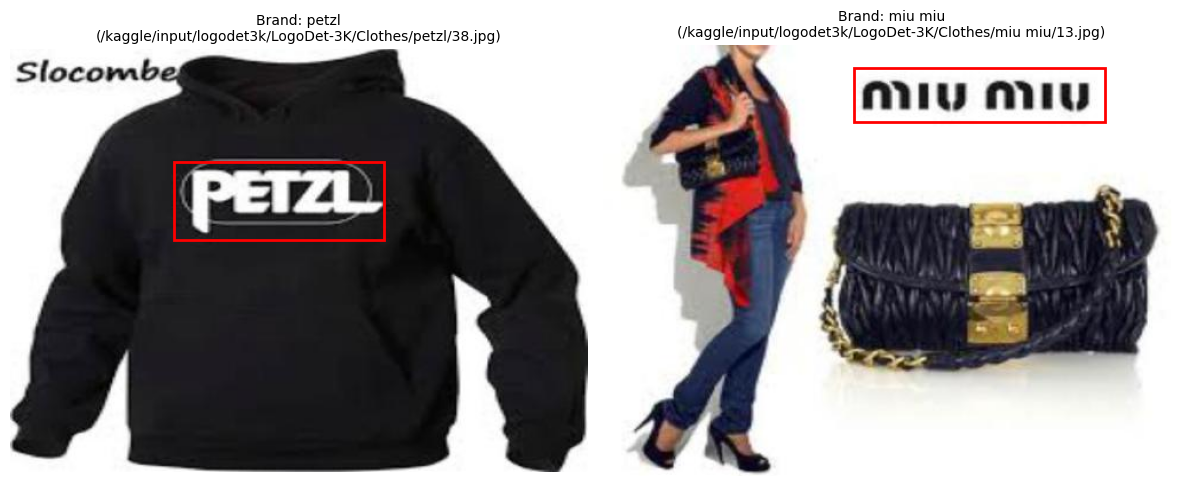

In [17]:
show_dataset_samples_with_bbox(full_dataset, 2)

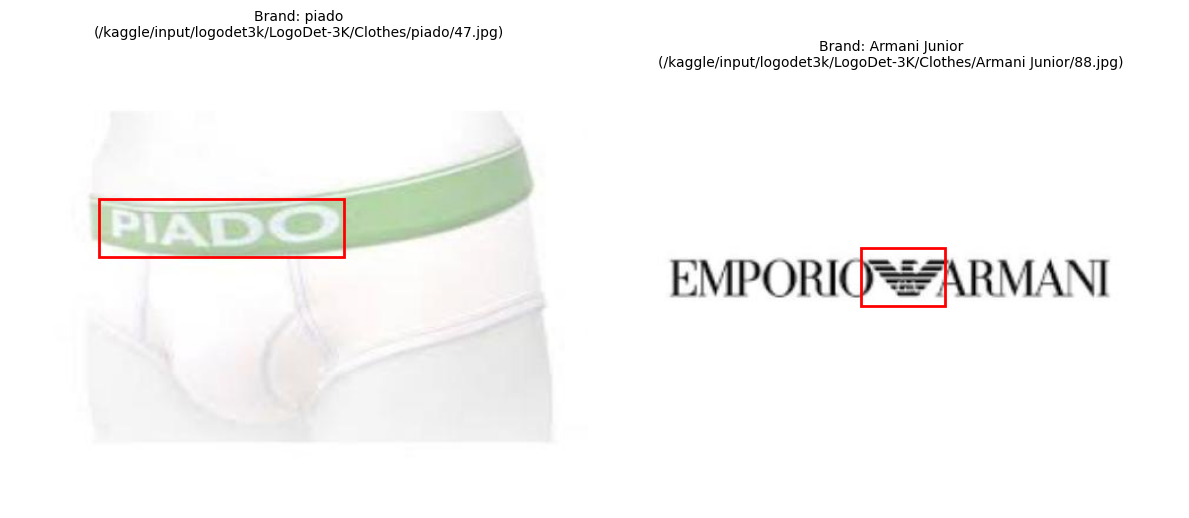

In [18]:
show_dataset_samples_with_bbox(full_dataset, 2)

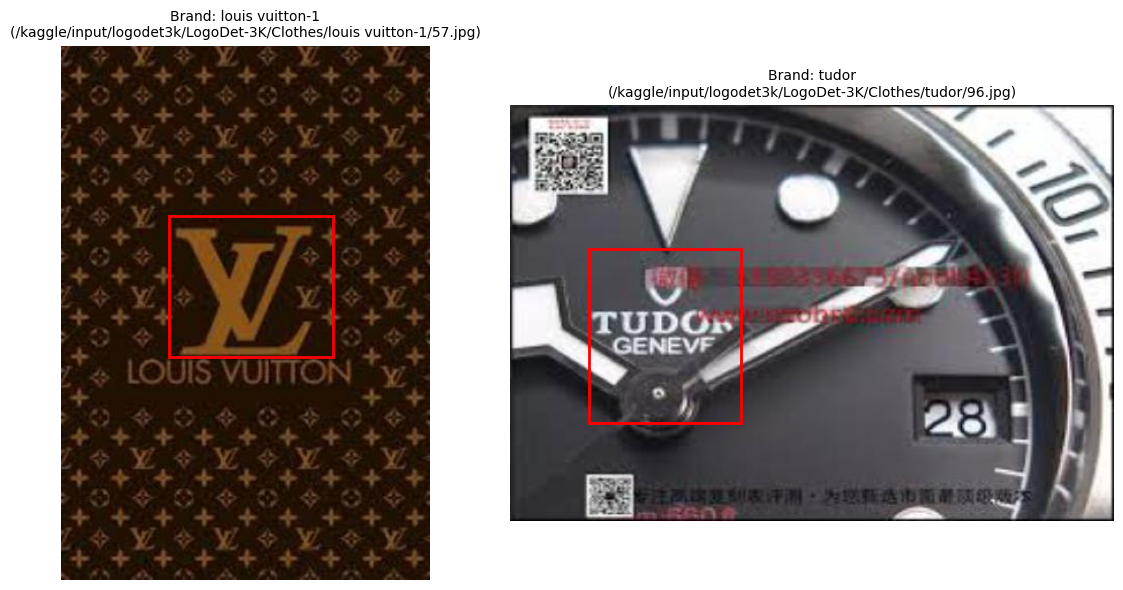

In [19]:
show_dataset_samples_with_bbox(full_dataset, 2)

In [20]:
train_and_validate()

model.safetensors:   0%|          | 0.00/7.56M [00:00<?, ?B/s]

Using DataParallel, GPUs = 2
Epoch 1/20 | Train Loss: 1.6200 | Val Acc: 19.48%
Epoch 2/20 | Train Loss: 1.2874 | Val Acc: 22.50%
Epoch 3/20 | Train Loss: 1.1365 | Val Acc: 24.48%
Epoch 4/20 | Train Loss: 1.0702 | Val Acc: 26.19%
Epoch 5/20 | Train Loss: 0.9324 | Val Acc: 27.18%
Epoch 6/20 | Train Loss: 0.8811 | Val Acc: 28.08%
Epoch 7/20 | Train Loss: 0.8304 | Val Acc: 28.61%
Epoch 8/20 | Train Loss: 0.7552 | Val Acc: 29.31%
Epoch 9/20 | Train Loss: 0.7305 | Val Acc: 29.74%
Epoch 10/20 | Train Loss: 0.6999 | Val Acc: 30.32%
Epoch 11/20 | Train Loss: 0.6817 | Val Acc: 30.91%
Epoch 12/20 | Train Loss: 0.6383 | Val Acc: 31.18%
Epoch 13/20 | Train Loss: 0.6020 | Val Acc: 31.77%
Epoch 14/20 | Train Loss: 0.5832 | Val Acc: 31.88%
Epoch 15/20 | Train Loss: 0.5517 | Val Acc: 32.33%
Epoch 16/20 | Train Loss: 0.5444 | Val Acc: 32.65%
Epoch 17/20 | Train Loss: 0.4972 | Val Acc: 32.87%
Epoch 18/20 | Train Loss: 0.4981 | Val Acc: 33.08%
Epoch 19/20 | Train Loss: 0.4747 | Val Acc: 33.48%
Epoch 20/20

In [23]:
if __name__ == "__main__":
    # 2) Загрузка модели
    model = LogoEncoder(emb_dim=EMB_DIM)
    ckpt = torch.load("lcnet_logo_encoder.pth", weights_only=True)
    model.load_state_dict(ckpt)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model = model.cuda().eval()

    brandX_imgs = [
        "/kaggle/input/logodet3k/LogoDet-3K/Clothes/Berghaus/0.jpg",
        "/kaggle/input/logodet3k/LogoDet-3K/Clothes/Berghaus/1.jpg"
    ]

    # Собираем эмбеддинги эталонов
    infer_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    reference_embs = []
    with torch.no_grad():
        for path in brandX_imgs:
            if not os.path.exists(path):
                print(f"[WARNING] File not found: {path}")
                continue
            rimg = Image.open(path).convert("RGB")
            rtensor = infer_transform(rimg).unsqueeze(0).cuda()
            emb = model(rtensor).squeeze(0)  # [emb_dim]
            reference_embs.append(emb)

    print(f"Collected {len(reference_embs)} reference emb(s) for brand 'Berghaus'")

    query_path = "/kaggle/input/logodet3k/LogoDet-3K/Clothes/Berghaus/10.jpg"
    if not os.path.exists(query_path):
        print(f"[WARNING] Query file not found: {query_path}")
    else:
        query_img = Image.open(query_path).convert("RGB")
        is_brandX, sim_val = verify_logo(query_img, reference_embs, model, threshold=0.65)
        print(f"\nQuery: {query_path}")
        print(f"Is brand Berghaus? {is_brandX}. Mean similarity = {sim_val:.2f}")

    query_path = "/kaggle/input/logodet3k/LogoDet-3K/Clothes/Boboli/1.jpg"
    if not os.path.exists(query_path):
        print(f"[WARNING] Query file not found: {query_path}")
    else:
        query_img = Image.open(query_path).convert("RGB")
        is_brandX, sim_val = verify_logo(query_img, reference_embs, model, threshold=0.65)
        print(f"\nQuery: {query_path}")
        print(f"Is brand Berghaus? {is_brandX}. Mean similarity = {sim_val:.2f}")

Collected 2 reference emb(s) for brand 'Berghaus'

Query: /kaggle/input/logodet3k/LogoDet-3K/Clothes/Berghaus/10.jpg
Is brand Berghaus? True. Mean similarity = 0.65

Query: /kaggle/input/logodet3k/LogoDet-3K/Clothes/Boboli/1.jpg
Is brand Berghaus? False. Mean similarity = -0.09
